In [272]:
from scipy import ndimage as ndi
from skimage import feature
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import pandas as pd
import sys
from astropy.table import Table
sys.path.append("../")
sys.path.append("../analysis")
from scipy import signal
from gradkde import kde
from gradkde import kernels
import analysis_utils

red = '#FE4365'
blue = '#00A9FF'
yellow = '#ECA25C'
green = '#3F9778'
darkblue = '#005D7F'

pl.rc('xtick', labelsize=20)
pl.rc('ytick', labelsize=20)
pl.rc('axes', labelsize=25)
pl.rc('axes', titlesize=30)
pl.rc('legend', handlelength=1)
pl.rc('legend', fontsize=20)

%matplotlib inline

In [273]:
import os
data = pd.DataFrame()
for file in os.listdir('../output/txtoutput'):
    print("reading file: {0}".format(file))
    data = data.append(pd.read_csv('../output/txtoutput/'+file, skiprows=1, delimiter='\t'))

reading file: out8.dat
reading file: out18.dat
reading file: out16.dat
reading file: out112.dat
reading file: out17.dat
reading file: out15.dat
reading file: out111.dat
reading file: out14.dat
reading file: out13.dat
reading file: out102.dat
reading file: out12.dat
reading file: out3.dat
reading file: out2.dat
reading file: out0.dat
reading file: out1.dat
reading file: out5.dat
reading file: out4.dat
reading file: out6.dat
reading file: out7.dat


In [274]:
k2dr2 = Table.read('../analysis/k2_dr2_1arcsec.fits', format='fits')
k2dr2 = k2dr2.to_pandas()
df = pd.merge(k2dr2, data, left_on='epic_number', right_on='epic')
df = df.drop_duplicates(subset='epic_number')

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: TableReplaceWarning: converted column 'r_result_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: TableReplaceWarning: converted column 'r_modality_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: TableReplaceWarning: converted column 'k2_kepmagerr' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [275]:
import imp
imp.reload(analysis_utils)
ms = analysis_utils.selectms(
    df, 
    '../analysis/MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd', 
    bp_rp_range=(0.0, 5.0),
    g_rp_range=(0.0, 5.0),
    width=(-0.6, 0.6)
)

Reading in: ../analysis/MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd


In [276]:
good_P = ms['P_mean'] / ms['P_sd'] > 15
good_P = good_P & (ms['P_mean'] < 32)
good_P = good_P & ((ms['logamp_mean'] - ms['logS0_mean']) > np.log(1e-3))

In [277]:
x = ms[good_P]['g_rp']
dx = np.sqrt((1/ms[good_P]['phot_g_mean_flux_error'])**2 + 
             (1/ms[good_P]['phot_rp_mean_flux_error'])**2)
y = np.log(ms[good_P]['P_mean'])
dy = ms[good_P]['P_sd']

data = np.vstack((x, y)).T

In [278]:
gauss = kernels.Gaussian()
kde1 = kde.KDE(gauss, 0.04, nderiv=0)
kde2 = kde.KDE(gauss, 0.04, nderiv=1)

kde1.condition(data)
kde2.condition(data)

gridx = np.linspace(x.min(), x.max(), 500)
gridy = np.linspace(y.min(), y.max(), 500)
grid = np.meshgrid(gridx, gridy)
points = np.concatenate(np.array(grid).T)

z1 = kde1.evaluate_on_grid(grid)
z2 = kde2.evaluate_on_grid(grid, separate_vectors=True)

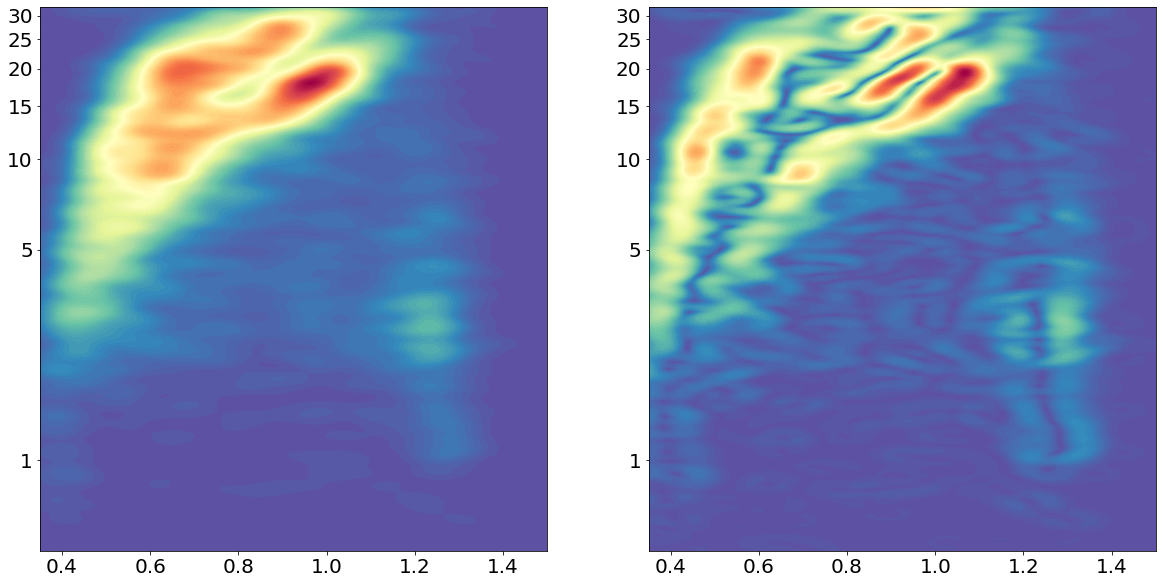

In [279]:
fig, ax = pl.subplots(1, 2, figsize=(20, 10))
ax[0].contourf(gridx, gridy, z1.T, 100, cmap='Spectral_r')
ax[1].contourf(gridx, gridy, np.linalg.norm(z2, axis=0).T, 100, cmap='Spectral_r')

ax[0].set_xlim(0.35, 1.5)
ax[0].set_ylim(np.log(0.5), np.log(32))
ax[1].set_xlim(0.35, 1.5)
ax[1].set_ylim(np.log(0.5), np.log(32))
ax[0].yaxis.set_major_formatter(pl.ScalarFormatter())
ax[1].yaxis.set_major_formatter(pl.ScalarFormatter())
ax[0].set_yticks(np.log([1, 5, 10, 15, 20, 25, 30]))
ax[0].set_yticklabels([1, 5, 10, 15, 20, 25, 30]);
ax[1].set_yticks(np.log([1, 5, 10, 15, 20, 25, 30]))
ax[1].set_yticklabels([1, 5, 10, 15, 20, 25, 30]);

In [280]:
import imp
imp.reload(analysis_utils)
edge_mask = analysis_utils.detect_edges(z2)

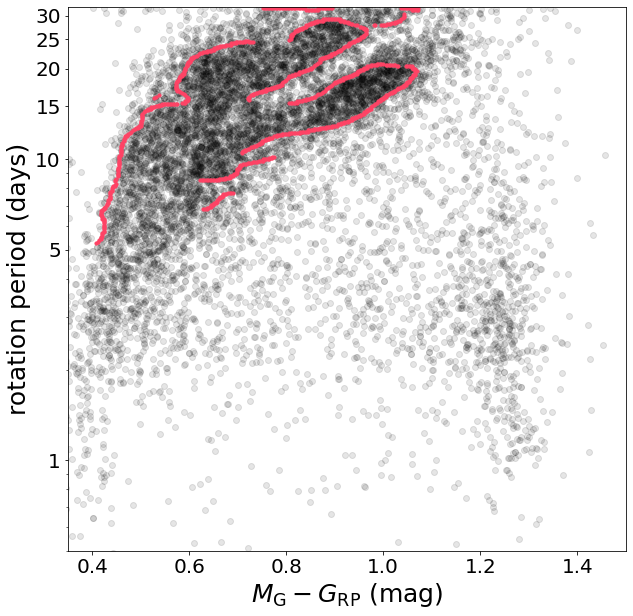

In [281]:
fx = z2[0]
fy = z2[1]
sigx =  np.sign(fx) * (np.sqrt(2 * np.pi) * np.abs(fx)) ** (-1/3)
sigy =  np.sign(fy) * (np.sqrt(2 * np.pi) * np.abs(fy)) ** (-1/3)
sigx = sigx[edge_mask.T]
sigy = sigy[edge_mask.T]

edge_x = grid[0][edge_mask.T]
edge_y = grid[1][edge_mask.T]

fig = pl.figure(figsize=(10, 10))
pl.yscale('log')
pl.xlim(0.35, 1.5)
pl.ylim(0.5, 32)
pl.plot(x, np.exp(y), 'ko', alpha=0.1, zorder=-1)
pl.scatter(edge_x, np.exp(edge_y), color=red, s=10)
pl.xlabel("$M_\mathrm{G} - G_\mathrm{RP}$ (mag)")
pl.ylabel("rotation period (days)")
pl.gca().yaxis.set_major_formatter(pl.ScalarFormatter())
pl.gca().set_yticks([1, 5, 10, 15, 20, 25, 30]);
pl.savefig('/Users/tgordon/Desktop/edges.pdf')

In [282]:
# make table of edge locations 
gaptrend = np.log(3.5*(7**edge_x))
gapmask = (edge_y - gaptrend > -0.2) & (edge_y - gaptrend < 0.16)
gapmask = gapmask & (edge_x > 0.6) & (edge_x < 1.02)
lower = (edge_y - gaptrend < 0)
upper = (edge_y - gaptrend > 0)

for bp_rp in [0.8, 0.85, 0.9, 0.95, 1.0]:
    
    up_edge = 0.0
    try:
        i_up = np.where(np.isclose(edge_x[gapmask & upper], bp_rp, atol=0.005))[0][0]
        up_edge = edge_y[gapmask & upper][i_up]
    except:
        i_up = 0
        up_edge = np.nan
    
    low_edge = 0.0
    try:
        i_low = np.where(np.isclose(edge_x[gapmask & lower], bp_rp, atol=0.005))[0][0]
        low_edge = edge_y[gapmask & lower][i_low]
    except:
        i_low = 0
        low_edge = np.nan
    width = up_edge - low_edge
    midpoint = low_edge + width / 2
    print("{:0.2f} & {:0.2f} & {:0.2f} & {:0.2f} & {:0.2f} \\\\".format(edge_x[gapmask & lower][i_low], 
                                                                        low_edge, 
                                                                        up_edge, 
                                                                        width, 
                                                                        midpoint))

0.81 & nan & 2.90 & nan & nan \\
0.85 & 2.76 & 2.99 & 0.23 & 2.88 \\
0.90 & 2.88 & 3.11 & 0.22 & 2.99 \\
0.95 & 2.96 & 3.22 & 0.26 & 3.09 \\
1.00 & 3.03 & 3.33 & 0.30 & 3.18 \\


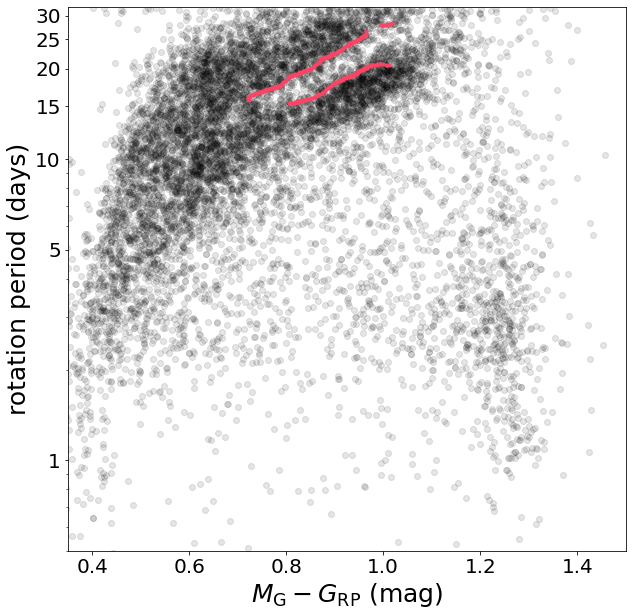

In [283]:
fig = pl.figure(figsize=(10, 10))
pl.yscale('log')
pl.xlim(0.35, 1.5)
pl.ylim(0.5, 32)
pl.plot(x, np.exp(y), 'ko', alpha=0.1, zorder=-1)
#pl.scatter(edge_x, np.exp(edge_y), color=red, s=10)
pl.plot(edge_x[gapmask & lower], np.exp(edge_y[gapmask & lower]), '.', color=red)
pl.plot(edge_x[gapmask & upper], np.exp(edge_y[gapmask & upper]), '.', color=red)
pl.xlabel("$M_\mathrm{G} - G_\mathrm{RP}$ (mag)")
pl.ylabel("rotation period (days)")
pl.gca().yaxis.set_major_formatter(pl.ScalarFormatter())
pl.gca().set_yticks([1, 5, 10, 15, 20, 25, 30]);
#pl.savefig('/Users/tgordon/Desktop/detected_edges.pdf')

<ipython-input-284-59bbf1d4a971>:4: RuntimeWarning: invalid value encountered in sqrt
  f = lambda x, a, b, x0: a * (x - x0) + b * (x - x0)**0.5


[ 64.20998224 -41.97142133  -0.11332737]
[26.09913811  7.91979719  0.42543653]


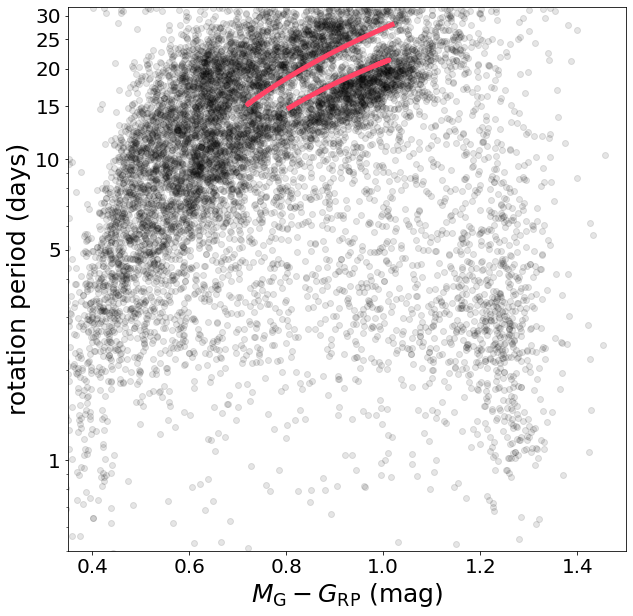

In [284]:
# fit edges
from scipy.optimize import curve_fit

f = lambda x, a, b, x0: a * (x - x0) + b * (x - x0)**0.5
params_up, _ = curve_fit(f, edge_x[gapmask & upper], np.exp(edge_y[gapmask & upper]), p0=[1, 1, 0])
params_low, _ = curve_fit(f, edge_x[gapmask & lower], np.exp(edge_y[gapmask & lower]), p0=[1, 1, 0])
print(params_up)
print(params_low)

fig = pl.figure(figsize=(10, 10))
pl.yscale('log')
pl.xlim(0.35, 1.5)
pl.ylim(0.5, 32)
pl.plot(x, np.exp(y), 'ko', alpha=0.1, zorder=-1)
pl.plot(edge_x[gapmask & upper], f(edge_x[gapmask & upper], *params_up), color=red, linewidth=5)
pl.plot(edge_x[gapmask & lower], f(edge_x[gapmask & lower], *params_low), color=red, linewidth=5)
pl.xlabel("$M_\mathrm{G} - G_\mathrm{RP}$ (mag)")
pl.ylabel("rotation period (days)")
pl.gca().yaxis.set_major_formatter(pl.ScalarFormatter())
pl.gca().set_yticks([1, 5, 10, 15, 20, 25, 30]);
pl.savefig('/Users/tgordon/Desktop/fit.pdf')

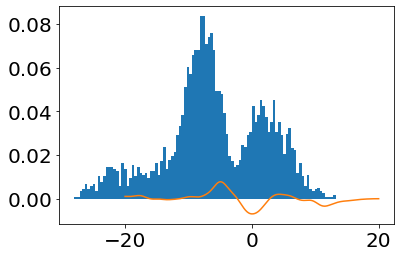

In [285]:
colormask = (x > 0.8) & (x < 1.05)
kde1d1 = kde.KDE(gauss, 1.0, nderiv=1)
kde1d1.condition(np.exp(y[colormask]) - f(x[colormask], *params_low))
kdex = np.linspace(-20, 20, 500)
kdey = kde1d1.evaluate(kdex)
pl.hist(np.exp(y[colormask]) - f(x[colormask], *params_up), bins=100, density=True);
pl.plot(kdex, kdey)

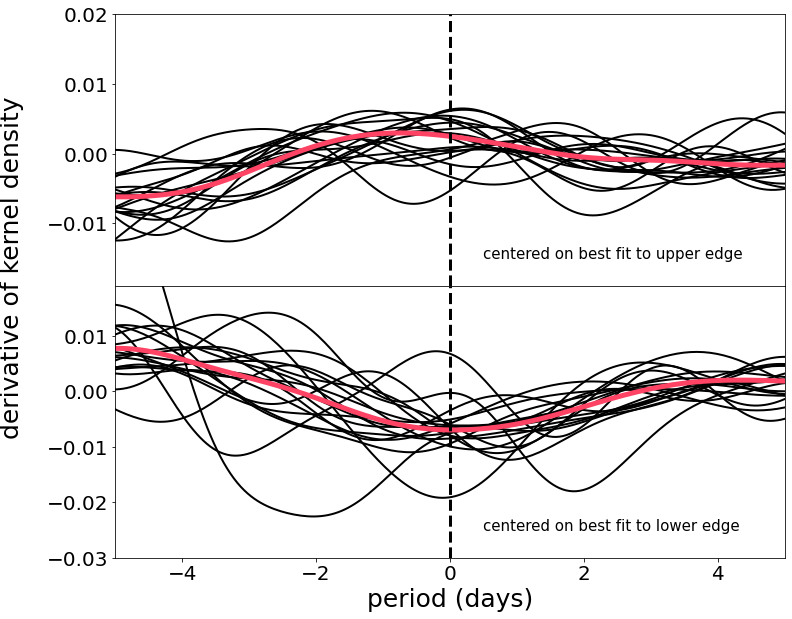

In [286]:
fig, axs = pl.subplots(2, 1, figsize=(12, 10), sharex=True)
fig.subplots_adjust(hspace=0.0)
campaigns = df['k2_campaign_str'].unique()
ngrid = 500
kdey_up = np.zeros(ngrid)[None, :]
for c in df['k2_campaign_str'].unique():
    xc, yc = x[df['k2_campaign_str'] == c], y[df['k2_campaign_str'] == c]

    kde1d = kde.KDE(gauss, 1.0, nderiv=1)
    kde1d.condition(np.exp(yc[colormask]) - f(xc[colormask], *params_up))

    kdex = np.linspace(-5, 5, ngrid)
    kdeyc = kde1d.evaluate(kdex)[None, :]
    kdey_up = np.append(kdey_up, kdeyc, axis=0)

    axs[0].plot(kdex, kdeyc[0], 'k-', linewidth=2, alpha=1.0)
    
# all campaigns
kde1d = kde.KDE(gauss, 1.0, nderiv=1)
kde1d.condition(np.exp(y[colormask]) - f(x[colormask], *params_up))
kdex = np.linspace(-5, 5, ngrid)
kdey_all = kde1d.evaluate(kdex)
axs[0].plot(kdex, kdey_all, color=red, linewidth=5)
axs[0].axvline([0.0], color='k', linewidth=3, linestyle='--')

axs[0].set_xlim(-5, 5)
axs[0].set_ylim(-0.019, 0.02)
axs[0].annotate("centered on best fit to upper edge", 
                xy=(0.55, 0.1), xycoords="axes fraction", fontsize=15)

campaigns = df['k2_campaign_str'].unique()
ngrid = 500
kdey_low = np.zeros(ngrid)[None, :]
for c in df['k2_campaign_str'].unique():
    xc, yc = x[df['k2_campaign_str'] == c], y[df['k2_campaign_str'] == c]

    kde1d = kde.KDE(gauss, 1.0, nderiv=1)
    kde1d.condition(np.exp(yc[colormask]) - f(xc[colormask], *params_low))

    kdex = np.linspace(-15, 10, ngrid)
    kdeyc = kde1d.evaluate(kdex)[None, :]
    kdey_low = np.append(kdey_low, kdeyc, axis=0)

    axs[1].plot(kdex, kdeyc[0], 'k-', linewidth=2, alpha=1.0)
    
# all campaigns
kde1d = kde.KDE(gauss, 1.0, nderiv=1)
kde1d.condition(np.exp(y[colormask]) - f(x[colormask], *params_low))
kdex = np.linspace(-15, 10, ngrid)
kdey_all = kde1d.evaluate(kdex)
axs[1].plot(kdex, kdey_all, color=red, linewidth=5)
axs[1].axvline([0.0], color='k', linewidth=3, linestyle='--')

axs[1].set_xlim(-5, 5)
axs[1].set_ylim(-0.03, 0.019)
axs[1].annotate("centered on best fit to lower edge", 
                xy=(0.55, 0.1), xycoords="axes fraction", fontsize=15)

pl.xlabel("period (days)")
pl.annotate("derivative of kernel density", xy=(0.0, 0.3), 
            xycoords="figure fraction", rotation=90, fontsize=25)

pl.savefig('/Users/tgordon/Desktop/kde1d.pdf')

In [287]:
campaigns = df['k2_campaign_str'].unique()
ngrid = 200
peaks_lower = np.zeros(len(campaigns))
for i, c in enumerate(df['k2_campaign_str'].unique()):
    xc, yc = x[df['k2_campaign_str'] == c], y[df['k2_campaign_str'] == c]

    kde1d = kde.KDE(gauss, 1.0, nderiv=1)
    kde1d.condition(np.exp(yc[colormask]) - f(xc[colormask], *params_low))

    kdex = np.linspace(-5, 5, ngrid)
    kdeyc = kde1d.evaluate(kdex)
    peak, peakdict = signal.find_peaks(-kdeyc, height=0.001)
    if len(peakdict['peak_heights']) > 0:
        peaks_lower[i] = kdex[peak[peakdict['peak_heights'].argmax()]]
    else:
        peaks_lower[i] = np.nan
        
from astropy.stats import bootstrap

kde2 = kde.KDE(gauss, 1.0, nderiv=1)
periods_upper = np.array(np.exp(y[colormask]) - f(x[colormask], *params_up))
periods_lower = np.array(np.exp(y[colormask]) - f(x[colormask], *params_low))

def upper_peak(periods):
    x = np.linspace(-5, 5, 20)
    kde2.condition(periods)
    y = kde2.evaluate(x)
    peaks, res = signal.find_peaks(y, height=0.001)
    try:
        peak_ind = np.argmax(res['peak_heights'])
        return x[peaks[peak_ind]]
    except Exception:
        print(Exception)
        return 5
    
def lower_peak(periods):
    x = np.linspace(-5, 5, 20)
    kde2.condition(periods)
    y = kde2.evaluate(x)
    peaks, res = signal.find_peaks(-y, height=0.001)
    try:
        peak_ind = np.argmax(res['peak_heights'])
        return x[peaks[peak_ind]]
    except Exception:
        print(Exception)
        return -5
    
sd_upper = np.zeros(len(campaigns))
sd_lower = np.zeros(len(campaigns))
for i, c in enumerate(df['k2_campaign_str'].unique()[:-1]):
    n = np.sum(ms[good_P]['k2_campaign_str'] == c)
    sd_upper[i] = np.std(bootstrap(data=periods_upper, bootnum=100, samples=n, bootfunc=upper_peak))
    sd_lower[i] = np.std(bootstrap(data=periods_lower, bootnum=100, samples=n, bootfunc=lower_peak))

<class 'Exception'>
<class 'Exception'>


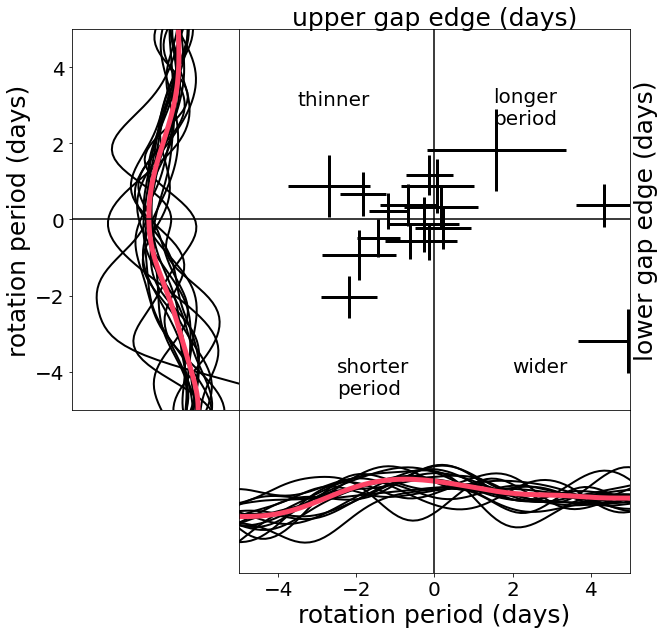

In [288]:
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse

campaigns = df['k2_campaign_str'].unique()
ngrid = 200
peaks_upper = np.zeros(len(campaigns))
for i, c in enumerate(df['k2_campaign_str'].unique()):
    xc, yc = x[df['k2_campaign_str'] == c], y[df['k2_campaign_str'] == c]

    kde1d = kde.KDE(gauss, 1.0, nderiv=1)
    kde1d.condition(np.exp(yc[colormask]) - f(xc[colormask], *params_up))

    kdex = np.linspace(-5, 5, ngrid)
    kdeyc = kde1d.evaluate(kdex)
    peak, peakdict = signal.find_peaks(kdeyc, height=0.001)
    if len(peakdict['peak_heights']) > 0:
        peaks_upper[i] = kdex[peak[peakdict['peak_heights'].argmax()]]
    else:
        peaks_upper[i] = np.nan
        
peaks_lower = np.zeros(len(campaigns))
for i, c in enumerate(df['k2_campaign_str'].unique()):
    xc, yc = x[df['k2_campaign_str'] == c], y[df['k2_campaign_str'] == c]

    kde1d = kde.KDE(gauss, 1.0, nderiv=1)
    kde1d.condition(np.exp(yc[colormask]) - f(xc[colormask], *params_low))

    kdex = np.linspace(-5, 5, ngrid)
    kdeyc = kde1d.evaluate(kdex)
    peak, peakdict = signal.find_peaks(-kdeyc, height=0.001)
    if len(peakdict['peak_heights']) > 0:
        peaks_lower[i] = kdex[peak[peakdict['peak_heights'].argmax()]]
    else:
        peaks_lower[i] = np.nan

fig = pl.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2, figure=fig, width_ratios=[0.3, 0.7], height_ratios=[0.7, 0.3], wspace=0, hspace=0)

left = fig.add_subplot(gs[0, 0])
corner = fig.add_subplot(gs[0, 1])
bottom = fig.add_subplot(gs[1, 1])

corner.get_yaxis().set_ticks([])
corner.get_xaxis().set_ticks([])
left.get_xaxis().set_ticks([])
bottom.get_yaxis().set_ticks([])

# scatter plot 
fill = mpl.colors.colorConverter.to_rgba(red, alpha=0.4)
#corner.scatter(peaks_upper, peaks_lower, s=np.sqrt(sd_upper**2 + sd_lower**2), edgecolor=(0, 0, 0, 1.0), color=fill)
corner.errorbar(peaks_upper, peaks_lower, xerr=sd_upper, yerr=sd_lower, linestyle='None', ecolor='k', elinewidth=3)

#for i, c in enumerate(df['k2_campaign_str'].unique()):
#    ell = Ellipse((peaks_upper[i], peaks_lower[i]), 
#                       2*sd_upper[i], 2*sd_lower[i], 
#                       edgecolor=(0, 0, 0, 1.0),
#                       color=fill)
#    corner.add_artist(ell)
#    if c in [b'18', b'5', b'17', b'13', b'7']:
#        corner.annotate(str(c).split("\'")[1], xy=(peaks_upper[i]-0.9, peaks_lower[i]+0.2), 
#                        xycoords='data', fontsize=14)

corner.set_xlim(-5, 5)
corner.set_ylim(-5, 5)
corner.axvline([0.0], color='k')
corner.axhline([0.0], color='k')
corner.annotate('wider', xy=(0.7, 0.1), xycoords='axes fraction', fontsize=20)
corner.annotate('thinner', xy=(0.15, 0.8), xycoords='axes fraction', fontsize=20)
corner.annotate('longer\nperiod', xy=(0.65, 0.75), xycoords='axes fraction', fontsize=20)
corner.annotate('shorter\nperiod', xy=(0.25, 0.04), xycoords='axes fraction', fontsize=20)

# plot derivatives of kdes by campaign for lower edge
ngrid = 200
kdey_low = np.zeros(ngrid)[None, :]
for c in df['k2_campaign_str'].unique():
    xc, yc = x[df['k2_campaign_str'] == c], y[df['k2_campaign_str'] == c]

    kde1d = kde.KDE(gauss, 1.0, nderiv=1)
    kde1d.condition(np.exp(yc[colormask]) - f(xc[colormask], *params_low))

    kdex = np.linspace(-15, 10, ngrid)
    kdeyc = kde1d.evaluate(kdex)[None, :]
    kdey_low = np.append(kdey_low, kdeyc, axis=0)

    left.plot(kdeyc[0], kdex, 'k-', linewidth=2, alpha=1.0)
    
# all campaigns
kde1d = kde.KDE(gauss, 1.0, nderiv=1)
kde1d.condition(np.exp(y[colormask]) - f(x[colormask], *params_low))
kdex = np.linspace(-15, 10, ngrid)
kdey_all = kde1d.evaluate(kdex)
left.plot(kdey_all, kdex, color=red, linewidth=5)
left.axhline([0.0], color='k')
left.set_ylim(-5, 5)
left.set_xlim(-0.03, 0.02)

# plot derivatives of kdes by campaign for upper edge
ngrid = 200
kdey_low = np.zeros(ngrid)[None, :]
for c in df['k2_campaign_str'].unique():
    xc, yc = x[df['k2_campaign_str'] == c], y[df['k2_campaign_str'] == c]

    kde1d = kde.KDE(gauss, 1.0, nderiv=1)
    kde1d.condition(np.exp(yc[colormask]) - f(xc[colormask], *params_up))

    kdex = np.linspace(-15, 10, ngrid)
    kdeyc = kde1d.evaluate(kdex)[None, :]
    kdey_low = np.append(kdey_low, kdeyc, axis=0)

    bottom.plot(kdex, kdeyc[0], 'k-', linewidth=2, alpha=1.0)
    
# all campaigns
kde1d = kde.KDE(gauss, 1.0, nderiv=1)
kde1d.condition(np.exp(y[colormask]) - f(x[colormask], *params_up))
kdex = np.linspace(-15, 10, ngrid)
kdey_all = kde1d.evaluate(kdex)
bottom.plot(kdex, kdey_all, color=red, linewidth=5)
bottom.axvline([0.0], color='k')
bottom.set_xlim(-5, 5)
bottom.set_ylim(-0.02, 0.02)


corner.yaxis.set_label_position('right')
corner.set_ylabel("lower gap edge (days)")
corner.xaxis.set_label_position('top')
corner.set_xlabel("upper gap edge (days)")

pl.xlabel("rotation period (days)")
left.set_ylabel("rotation period (days)")
left.xaxis.set_label_position('top')
#left.set_xlabel("derivative of\nkernel density", fontsize=10)
#bottom.set_ylabel("derivative of\nkernel density", fontsize=10)

#corner.annotate("5", xy=(0.35, 0.32), xycoords='axes fraction', fontsize=15)
#corner.annotate("18", xy=(0.42, 0.15), xycoords='axes fraction', fontsize=15)
#corner.annotate("17", xy=(0.62, 0.18), xycoords='axes fraction', fontsize=15)
#corner.annotate("13", xy=(0.63, 0.35), xycoords='axes fraction', fontsize=15)

pl.savefig('/Users/tgordon/Desktop/edges_campaign.pdf')

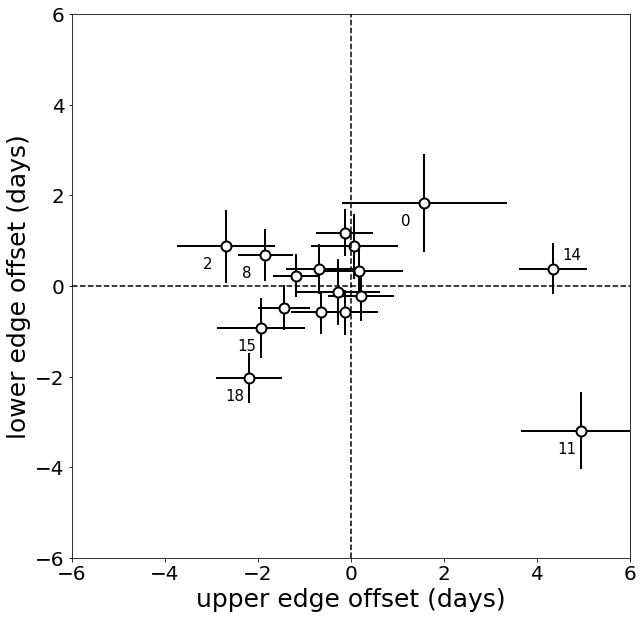

In [328]:
pl.figure(figsize=(10, 10))
pl.errorbar(peaks_upper, peaks_lower, xerr=sd_upper, yerr=sd_lower, 
            linestyle='None', ecolor='k', elinewidth=2)
pl.plot(peaks_upper, peaks_lower, 'wo', markersize=10, markeredgecolor='k', markeredgewidth=2)
for c, u, l in zip(df['k2_campaign_str'].unique(), peaks_upper, peaks_lower):
    if c in [b'2', b'8', b'15', b'18', b'0', b'14', b'11']:
        if c != b'14':
            pl.annotate(str(c)[2:-1], xy=(u-0.5, l-0.5), fontsize=15)
        else:
            pl.annotate(str(c)[2:-1], xy=(u+0.2, l+0.2), fontsize=15)
pl.axvline(0, linestyle='--', color='k')
pl.axhline(0, linestyle='--', color='k')
pl.xlim(-6, 6)
pl.ylim(-6, 6)
pl.xlabel("upper edge offset (days)")
pl.ylabel("lower edge offset (days)")
pl.savefig('/Users/tgordon/Desktop/edges_campaign.pdf')